In [1]:
import geopandas as gpd
import pandas as pd
import os
import numpy as np
from scipy.optimize import curve_fit

In [2]:
file_province = "province.geojson"
map_df = gpd.read_file(file_province)
map_df = map_df.rename(index=str, columns={"prov_name": "provincia"})
map_df = map_df[['provincia','geometry']]
map_df.head()

provincia                                           geometry
0    Torino  POLYGON ((7.89397 45.58222, 7.89654 45.57985, ...
1  Vercelli  POLYGON ((7.92900 45.74244, 7.92584 45.74196, ...
2    Novara  POLYGON ((8.42079 45.82981, 8.42028 45.83010, ...
3     Cuneo  MULTIPOLYGON (((6.94540 44.42794, 6.94734 44.4...
4      Asti  POLYGON ((7.96685 45.11667, 7.96729 45.11673, ...

In [3]:
from matplotlib import pyplot as plt

map_df.plot(figsize=(10,10))

In [4]:
map_df

provincia                                           geometry
0          Torino  POLYGON ((7.89397 45.58222, 7.89654 45.57985, ...
1        Vercelli  POLYGON ((7.92900 45.74244, 7.92584 45.74196, ...
2          Novara  POLYGON ((8.42079 45.82981, 8.42028 45.83010, ...
3           Cuneo  MULTIPOLYGON (((6.94540 44.42794, 6.94734 44.4...
4            Asti  POLYGON ((7.96685 45.11667, 7.96729 45.11673, ...
..            ...                                                ...
102       Sassari  MULTIPOLYGON (((9.46502 40.65584, 9.46475 40.6...
103         Nuoro  MULTIPOLYGON (((9.28037 39.91741, 9.27741 39.9...
104      Cagliari  MULTIPOLYGON (((9.00622 39.32697, 9.01541 39.3...
105      Oristano  MULTIPOLYGON (((8.78200 40.18982, 8.78829 40.1...
106  Sud Sardegna  MULTIPOLYGON (((8.50222 39.71303, 8.50016 39.7...

[107 rows x 2 columns]

In [5]:
# Getting the latest diseases data

In [6]:
!wget https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv
!mv dpc-covid19-ita-province.csv covid_province.csv

--2020-03-24 19:52:23--  https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-province/dpc-covid19-ita-province.csv
Risoluzione di raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.240.133
Connessione a raw.githubusercontent.com (raw.githubusercontent.com)|151.101.240.133|:443... connesso.
Richiesta HTTP inviata, in attesa di risposta... 200 OK
Lunghezza: 306133 (299K) [text/plain]
Salvataggio in: "dpc-covid19-ita-province.csv"

dpc-covid19-ita-pro 100%[===================>] 298,96K  1,93MB/s    in 0,2s    

2020-03-24 19:52:24 (1,93 MB/s) - "dpc-covid19-ita-province.csv" salvato [306133/306133]



In [7]:
df = pd.read_csv("covid_province.csv", header=0)
df.tail()

data stato  codice_regione denominazione_regione  \
3835  2020-03-24 17:00:00   ITA               5                Veneto   
3836  2020-03-24 17:00:00   ITA               5                Veneto   
3837  2020-03-24 17:00:00   ITA               5                Veneto   
3838  2020-03-24 17:00:00   ITA               5                Veneto   
3839  2020-03-24 17:00:00   ITA               5                Veneto   

      codice_provincia               denominazione_provincia sigla_provincia  \
3835                26                               Treviso              TV   
3836                27                               Venezia              VE   
3837                23                                Verona              VR   
3838                24                               Vicenza              VI   
3839               999  In fase di definizione/aggiornamento             NaN   

            lat       long  totale_casi  
3835  45.667546  12.245074         1091  
3836  45.434905  12.338452          837  
3837  45.438390  10.993527         1228  
3838  45.547497  11.545971          744  
3839   0.000000   0.000000          229

In [8]:
# Slicing a single part
df = df[['data','denominazione_provincia','totale_casi']]
df = df[~df.denominazione_provincia.str.contains('aggiornamento')]
data_for_map = df.rename(index=str, columns={
    "denominazione_provincia": "provincia",
    "totale_casi": "casi"})
data_for_map

data provincia  casi
0     2020-02-24 18:00:00    Chieti     0
1     2020-02-24 18:00:00  L'Aquila     0
2     2020-02-24 18:00:00   Pescara     0
3     2020-02-24 18:00:00    Teramo     0
5     2020-02-24 18:00:00    Matera     0
...                   ...       ...   ...
3834  2020-03-24 17:00:00    Rovigo    82
3835  2020-03-24 17:00:00   Treviso  1091
3836  2020-03-24 17:00:00   Venezia   837
3837  2020-03-24 17:00:00    Verona  1228
3838  2020-03-24 17:00:00   Vicenza   744

[3210 rows x 3 columns]

Elaborazione dei dati sulla popolazione

In [9]:
pop = pd.read_csv("popolazione_province.csv", header=0)
pop = pop[pop.Sesso.str.contains('totale')]
pop = pop[pop.ETA1.str.contains("TOTAL")]
pop = pop[pop["Stato civile"].str.contains("totale")]
pop = pop[pop.Territorio.isin(data_for_map.provincia.tolist())]
pop = pop[['Territorio','Value']]
pop = pop.rename(index=str, columns={
    "Territorio": "provincia",
    "Value": "popolazione"})

# Unione con quello sui casi
data_for_map = data_for_map.set_index("provincia").join(pop.set_index("provincia"))
data_for_map

data  casi  popolazione
provincia                                        
Agrigento  2020-02-24 18:00:00     0     434870.0
Agrigento  2020-02-25 18:00:00     0     434870.0
Agrigento  2020-02-26 18:00:00     0     434870.0
Agrigento  2020-02-27 18:00:00     0     434870.0
Agrigento  2020-02-28 18:00:00     0     434870.0
...                        ...   ...          ...
Viterbo    2020-03-20 17:00:00    63     317030.0
Viterbo    2020-03-21 17:00:00    72     317030.0
Viterbo    2020-03-22 17:00:00    82     317030.0
Viterbo    2020-03-23 17:00:00    93     317030.0
Viterbo    2020-03-24 17:00:00   121     317030.0

[3210 rows x 3 columns]

In [10]:
from datetime import datetime

now = datetime.now()
start_date = datetime(2020, 2, 24)
print(start_date.strftime("%Y-%m-%d"))

2020-02-24


In [11]:
from datetime import datetime, timedelta
import matplotlib.colors as colors

def plot_casi(df, maxvalue=None, variabile='casi', data='', index = None, label = ""):
    if maxvalue is None:
        maxvalue = df.casi.max()
     
    # Personalizzazione colorbar
    if "densita" in variabile:
        vmin = 1e-5
    else:
        vmin = 1
        
    # Plot a styling
    fig = df.plot(column=variabile, cmap="coolwarm", linewidth=0.8, edgecolor='0.8',
                  figsize=(6,6), 
                  norm=colors.LogNorm(vmin=vmin, vmax=maxvalue),
                  legend=True, 
                  legend_kwds={'label': label,
                               'orientation': "vertical",
                               'fraction': 0.10,
                               'extend': 'max'}
                 )
    fig.axis('off')
    title = label + ' (' + data + ')'
    fig.set_title(title, \
              fontdict={'fontsize': '12',
                         'fontweight' : '2'})
    lims = plt.axis('equal')
    
    # Salvataggio
    if index is None:
        filename = data + '.png'
    else:
        filename = index + '.png'
    filepath = os.path.join("frames", filename)
    chart = fig.get_figure()
    chart.savefig(filepath, dpi=80)
    
    print(title)
    plt.close("all")
    return 

def elaborate(current_cases, old_cases):
    # Calcolo variazione
    data = current_cases.join(old_cases["casi"].rename("vecchi_casi"))
    data['variazione'] = data['casi'] - data['vecchi_casi']

    # Casi per popolazione
    data['densita_casi_perc'] = 100.*data['casi']/data['popolazione']
    data['densita_variazione_perc'] = 100.*data['variazione']/data['popolazione']
    return data

def make_gif(data_for_map, map_df, variabile, label):
    
    now = datetime.now()# - timedelta(1)
    current_date = datetime(2020, 2, 25)
    dfs_to_plot = []
    i = 0
    maxval = 0.
    while current_date <= now:
        old_cases = data_for_map[
            data_for_map.data.str.startswith(
                (current_date-timedelta(days=1)).strftime("%Y-%m-%d")
            )
        ]
        current_cases = data_for_map[
            data_for_map.data.str.startswith(
                current_date.strftime("%Y-%m-%d")
            )
        ]
        
        data = elaborate(current_cases, old_cases)
        
        merged = map_df.set_index("provincia").join(data)
        dfs_to_plot.append({
            "date": current_date.strftime("%Y-%m-%d"),
            "index": i,
            "df": merged
        })
        
        if maxval < merged[variabile].max():
            maxval = merged[variabile].max()
        # Update current date for while loop
        current_date += timedelta(days=1)
        i += 1
    
    # Making the figures
    for df in dfs_to_plot:
        plot_casi(df["df"], maxval, variabile=variabile, data=df["date"], 
                  index="{}".format(df["index"]).zfill(3), label=label)
        
def fsigmoid(x, a, b, c):
    return c / (1.0 + np.exp(-a*(x-b)))

def sir_solution(x, b, t, x0, y0):
    k = x0/y0
    return 1 - (x0+y0)*np.exp(-b*k*(x-t)/(1+k))

def sqrt_sigmoid(x, a, b, c):
    return np.sqrt(fsigmoid(x, a, b, c))

def d_sigmoid(x,a,b,c):
    return fsigmoid(x, a, b, c)*(1-fsigmoid(x, a, b, c)/c)

def sample_curves(func,mean,cov,support,N=100):
    params = np.random.multivariate_normal(mean, cov, N)
    curves = []
    for popt in params:
        curves.append(func(_support["xcurva"], *popt)*support["yscale"])
    return curves

def plot_provincia(data, provincia):
    data = data[data.provincia.str.contains(provincia)].set_index("data")
    casi = data["casi"].to_numpy()
    casi = casi[casi!=0]
    d_casi = np.gradient(casi)
    x = np.arange(casi.size)
    
    # normalization
    xmax = np.max(x)
    ymax = np.max(casi)
    x = x/xmax
    casi = casi/ymax
    
    # Fit sigmoid
    popt, pcov = curve_fit(fsigmoid, x, casi, method='lm', maxfev=50000)
    x_curva = np.linspace(0, np.max(x)*3, 200)
    casi_fit = fsigmoid(x_curva, *popt)
    #d_casi_fit = d_sigmoid(x_curva, *popt)
    
    plt.figure(figsize=(15, 5))
    plt.plot(x*xmax, casi*ymax, 'x')
    plt.plot(x_curva*xmax, casi_fit*ymax)
    
    #plt.plot(x*xmax, d_casi, 'o')
    #plt.plot(x_curva*xmax, d_casi_fit*ymax)
    
    return popt, pcov, {
        "xscale": xmax,
        "yscale": ymax,
        "casi": casi*ymax,
        "x": x*xmax,
        "xcurva": x_curva
    }

In [12]:
merged = map_df.set_index("provincia").join(data_for_map).reset_index()

[6.35886573 0.90337753 1.58275895]
[[ 0.10467458 -0.00800411 -0.0375696 ]
 [-0.00800411  0.00071381  0.00339388]
 [-0.0375696   0.00339388  0.01637264]]


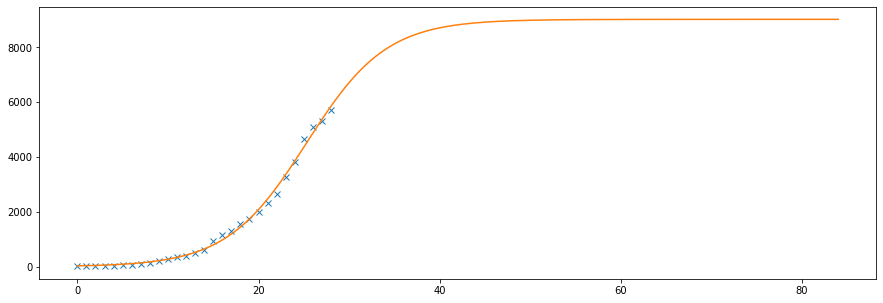

In [13]:
merged['densita_casi_perc'] = 100.*merged['casi']/merged['popolazione']
popt, pcov, _support = plot_provincia(merged, "Milano")
print(popt)
print(pcov)

In [14]:
curves = sample_curves(fsigmoid,popt,pcov,N=1000,support=_support)
curves = np.stack(curves)
print(curves.shape)

(1000, 200)


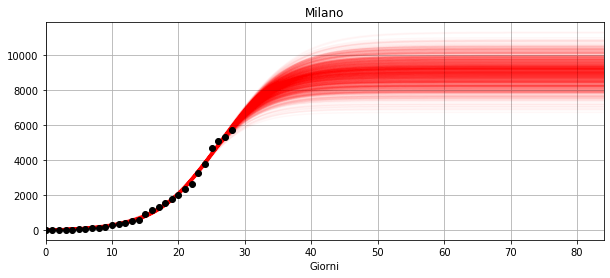

In [15]:
plt.figure(figsize=(10,4))
plt.plot(_support["xcurva"]*_support["xscale"], curves.T, alpha=0.03, color="red")
plt.plot(_support["x"], _support["casi"], 'o', color="black")
plt.xlim([0,np.max(_support["x"])*3])
plt.title("Milano")
plt.xlabel("Giorni")
plt.grid()
plt.show()

In [17]:
make_gif(data_for_map, map_df, variabile= "densita_casi_perc", label = "100 x Casi / Popolazione")
!convert -delay 40 frames/*.png -delay 200 frames/028.png -loop 0 img/densita_casi.gif

make_gif(data_for_map, map_df, variabile= "densita_variazione_perc", label = "100 x Nuovi Casi / Popolazione")
!convert -delay 40 frames/*.png -delay 200 frames/028.png -loop 0 img/densita_nuovi.gif

make_gif(data_for_map, map_df, variabile= "casi", label = "Casi Totali")
!convert -delay 40 frames/*.png -delay 200 frames/028.png -loop 0 img/casi_totali.gif

make_gif(data_for_map, map_df, variabile= "variazione", label = "Nuovi Casi")
!convert -delay 40 frames/*.png -delay 200 frames/028.png -loop 0 img/evoluzione_spaziale.gif

100 x Casi / Popolazione (2020-02-25)
100 x Casi / Popolazione (2020-02-26)
100 x Casi / Popolazione (2020-02-27)
100 x Casi / Popolazione (2020-02-28)
100 x Casi / Popolazione (2020-02-29)
100 x Casi / Popolazione (2020-03-01)
100 x Casi / Popolazione (2020-03-02)
100 x Casi / Popolazione (2020-03-03)
100 x Casi / Popolazione (2020-03-04)
100 x Casi / Popolazione (2020-03-05)
100 x Casi / Popolazione (2020-03-06)
100 x Casi / Popolazione (2020-03-07)
100 x Casi / Popolazione (2020-03-08)
100 x Casi / Popolazione (2020-03-09)
100 x Casi / Popolazione (2020-03-10)
100 x Casi / Popolazione (2020-03-11)
100 x Casi / Popolazione (2020-03-12)
100 x Casi / Popolazione (2020-03-13)
100 x Casi / Popolazione (2020-03-14)
100 x Casi / Popolazione (2020-03-15)
100 x Casi / Popolazione (2020-03-16)
100 x Casi / Popolazione (2020-03-17)
100 x Casi / Popolazione (2020-03-18)
100 x Casi / Popolazione (2020-03-19)
100 x Casi / Popolazione (2020-03-20)
100 x Casi / Popolazione (2020-03-21)
100 x Casi /